<a href="https://colab.research.google.com/github/rivaelsagala/project-PM-kel-05/blob/main/ModelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!git clone https://github.com/rivaelsagala/project-PM-kel-05.git


fatal: destination path 'project-PM-kel-05' already exists and is not an empty directory.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [77]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [79]:
import os
print(os.listdir("project-PM-kel-05/dataset/train/"))


['red_devil', 'sepat', 'mujahir']


## Membuat Classifier nya


In [4]:
import tensorflow as tf

In [5]:
# Parameter input untuk network
dim = (150, 150)           # Sesuaikan dengan ukuran gambar dari dataset Roboflow
channel = (3, )            # RGB channel
input_shape = dim + channel
# Batch size
batch_size = 8             # Gunakan batch size yang lebih kecil jika GPU terbatas
# Epoch
epoch = 10                 # Tetap 10 untuk eksperimen awal


## Membuat dataset generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Mendefinisikan Data |Generatornya

In [9]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1. / 255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)





## Mendefinisikan asal folder sumber file berasal

In [14]:
# Load data
train_generator = train_datagen.flow_from_directory('project-PM-kel-05/dataset/train/',
                                                    target_size=dim,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory('project-PM-kel-05/dataset/validation/',
                                                target_size=dim,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_datagen.flow_from_directory('project-PM-kel-05/dataset/test/',
                                                  target_size=dim,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)




Found 601 images belonging to 3 classes.
Found 76 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


In [ ]:
print(labels)

{'mujahir': 0, 'red_devil': 1, 'sepat': 2}


In [21]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # Change the number of units in the output layer to 3 to match the number of classes
    tf.keras.layers.Dense(3, activation='softmax') # Changed from 6 to 3
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(optimizer=tf.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [23]:
history = model.fit(train_generator,
               validation_data=val_generator, # Change validation_generator to val_generator
               epochs=10,
               verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 - 51s - 676ms/step - accuracy: 0.3710 - loss: 1.1789 - val_accuracy: 0.4474 - val_loss: 1.0802
Epoch 2/10
76/76 - 44s - 585ms/step - accuracy: 0.6972 - loss: 0.7313 - val_accuracy: 0.8553 - val_loss: 0.5912
Epoch 3/10
76/76 - 43s - 564ms/step - accuracy: 0.8253 - loss: 0.5264 - val_accuracy: 0.8947 - val_loss: 0.3542
Epoch 4/10
76/76 - 43s - 566ms/step - accuracy: 0.8852 - loss: 0.2952 - val_accuracy: 0.8816 - val_loss: 0.3394
Epoch 5/10
76/76 - 83s - 1s/step - accuracy: 0.8453 - loss: 0.4235 - val_accuracy: 0.9079 - val_loss: 0.3856
Epoch 6/10
76/76 - 84s - 1s/step - accuracy: 0.9135 - loss: 0.2557 - val_accuracy: 0.8553 - val_loss: 0.5000
Epoch 7/10
76/76 - 45s - 592ms/step - accuracy: 0.9301 - loss: 0.2235 - val_accuracy: 0.9474 - val_loss: 0.1565
Epoch 8/10
76/76 - 80s - 1s/step - accuracy: 0.9584 - loss: 0.1451 - val_accuracy: 0.8553 - val_loss: 0.2769
Epoch 9/10
76/76 - 42s - 556ms/step - accuracy: 0.9617 - loss: 0.1369 - val_accuracy: 0.9605 - val_loss: 0.1529
Epoch 10/10


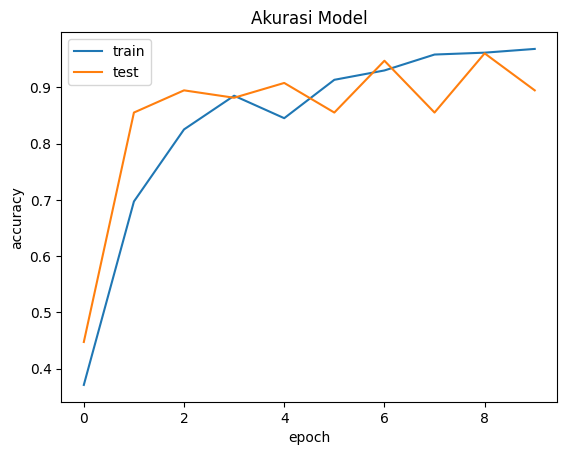

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Membuat tf.data untuk kompabilitas yang lebih baik untuk tensorflow 2.1 (tf.keras)

In [ ]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, input_shape[0], input_shape[1], input_shape[2]), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_class), dtype=tf.float32)
        )
    )
    return tf_generator

In [ ]:
train_data = tf_data_generator(train_generator, input_shape)
test_data = tf_data_generator(test_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

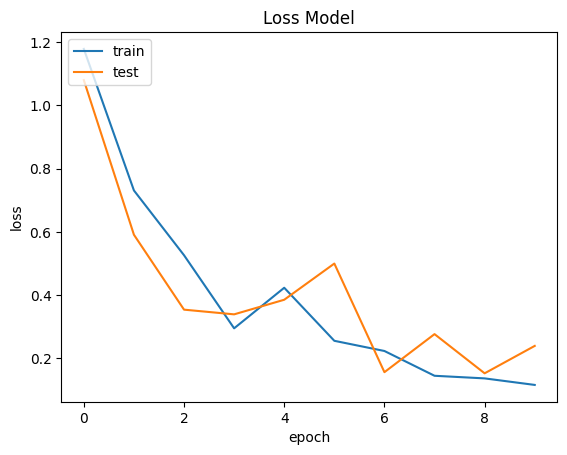

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Verifikasi Dataset

In [ ]:
for data, labels in train_data.take(1):  # Ambil satu batch
    print("Data shape:", data.shape)
    print("Labels shape:", labels.shape)

Data shape: (8, 224, 224, 3)
Labels shape: (8, 3)


## Membuat Struktur CNN

## Manualy define network

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi Data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Definisikan model
model = Sequential()
model.add(Input(shape=input_shape))  # Layer input
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_class))
model.add(Activation('softmax'))

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Implementasi Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



Compiling Model.......


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    95,552,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,649,443 (364.87 MB)

 Trainable params: 95,649,443 (364.87 MB)

 Non-trainable params: 0 (0.00 B)

## Using Pre-trained model / Transfer Learning

## Prebuild model

## Build Base Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# get base models
input_shape = (224, 224, 3)
base_model = MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    classes=num_class
)


## Add top layer network

In [ ]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [ ]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# model.summary()

In [ ]:
# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Effinet

In [ ]:
pip install efficientnet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from efficientnet.tfkeras import EfficientNetB1

## Prebuild model

## Build Base model

In [ ]:
# get base models
base_model = EfficientNetB1(
    input_shape=input_shape,
    include_top=False,
    weights='noisy-student',
    classes=num_class,
)

## Add top network layer to models

In [ ]:
from tensorflow.keras import layers,Sequential
from tensorflow.keras.models import Model

In [ ]:
#Adding custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation="relu")(x)

predictions = layers.Dense(num_class, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
#model.summary()

In [ ]:

# Compile the model
print('Compiling Model.......')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Compiling Model.......


## Visualize The final model


In [ ]:
pip install visualkeras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
pip install netron

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf
import visualkeras
import netron

# ... (Your model definition) ...

# Option 1: Using visualkeras
visualkeras.layered_view(model, to_file='model_visualkeras.png').show() # display the image

# # Option 2: Using netron
# model.save('project-PM-kel-05/model.h5')
# netron.start('project-PM-kel-05/model.h5')

c:\Users\M S I\AppData\Local\Programs\Python\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
# model_viz = tf.keras.utils.plot_model(model,
#                           to_file='model.png',
#                           show_shapes=True,
#                           show_layer_names=True,
#                           rankdir='TB',
#                           expand_nested=True,
#                           dpi=55)
# model_viz

In [ ]:
# pip install pydot

  Using cached pydot-3.0.2-py3-none-any.whl.metadata (10 kB)
Using cached pydot-3.0.2-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Train Model

In [ ]:
epochs = 10

In [ ]:
history = model.fit(x=train_data,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=val_data,
        validation_steps=len(val_generator),
        shuffle=True,
        verbose = 1)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9145 - loss: 0.3880 - val_accuracy: 0.6316 - val_loss: 4.9238
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9564 - loss: 0.1668 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9543 - loss: 0.1919 - val_accuracy: 0.9474 - val_loss: 0.1032
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9434 - loss: 0.1878 - val_accuracy: 0.9737 - val_loss: 0.0786
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9563 - loss: 0.2520 - val_accuracy: 1.0000 - val_loss: 7.4831e-04
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9670 - loss: 0.0791 - val_accuracy: 1.0000 - val_loss: 4.5803e-04
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9679 - loss: 0.1034 - val_accuracy: 1.0000 - val_loss: 4.9076e-04
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9958 - loss: 0.0250 - val_accuracy

In [ ]:
history.history['loss']

[0.218908429145813,
 0.13572220504283905,
 0.18987415730953217,
 0.15824995934963226,
 0.13683849573135376,
 0.06074804440140724,
 0.07921381294727325,
 0.05043156072497368,
 0.06372079253196716,
 0.07597362250089645]

In [ ]:
history.history['accuracy']

[0.9434276223182678,
 0.9667221307754517,
 0.9467554092407227,
 0.9484192728996277,
 0.9633943438529968,
 0.9767054915428162,
 0.9750415682792664,
 0.9900166392326355,
 0.981697142124176,
 0.980033278465271]

## Plot the training

In [ ]:
from matplotlib import pyplot as plt

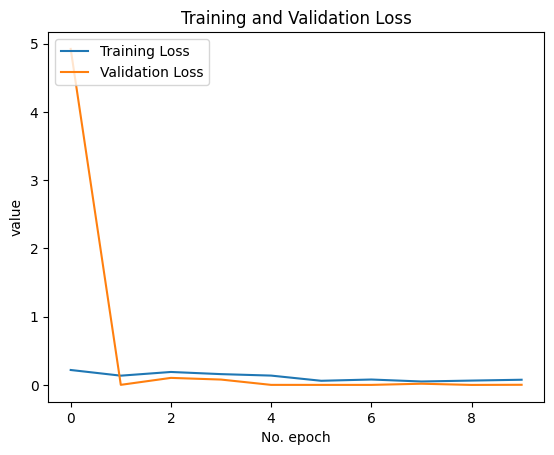

In [ ]:
# Plot history: MAE
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

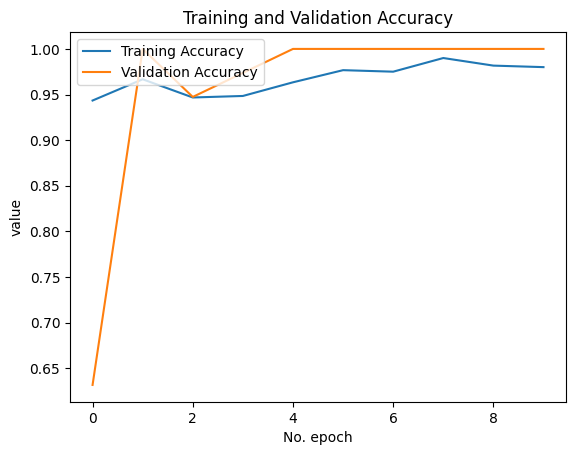

In [ ]:
# Plot history: MSE
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Save Model

In [ ]:
import os

In [27]:
MODEL_BASE_PATH = "model"
PROJECT_NAME = "fish_project"
SAVE_MODEL_NAME = "/content/project-PM-kel-05/modelmodel.keras"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)

if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

print('Saving Model At {}...'.format(save_model_path))
model.save(save_model_path)

Saving Model At /content/project-PM-kel-05/modelmodel.keras...


In [ ]:
import os
print("Current working directory:", os.getcwd())
print("Files in the current directory:", os.listdir())


Current working directory: c:\Users\M S I\PM\Project-PM\project-PM-kel-05
Files in the current directory: ['.git', '.ipynb_checkpoints', 'best_model.keras', 'dataset', 'Jurnal', 'model', 'model.png', 'ModelTrain.ipynb', 'model_visualkeras.png', 'new_data', 'Original_dataset', 'PredictFunction.ipynb', 'SplitDataset.ipynb']


## Evaluate Models

In [28]:
loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

loss, acc = model.evaluate(test_data,steps=len(test_generator),verbose=0)
print('Accuracy on test data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

NameError: name 'test_data' is not defined

In [44]:
import requests
from io import BytesIO


from PIL import Image
import numpy as np

In [45]:
# Parameters
input_size = (150,150)

#define input shape
channel = (3,)
input_shape = input_size + channel

#define labels
labels = ['mujahir', 'red_devil', 'sepat']

In [58]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(im, input_size):
    im = im.resize(input_size)  # Resize gambar
    im = np.array(im)  # Konversi ke array
    im = preprocess_input(im)  # Normalisasi sesuai EfficientNet
    return im


In [49]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00


In [59]:
from tensorflow.keras.models import load_model
from tensorflow.keras.activations import swish
from tensorflow.keras.utils import get_custom_objects
import efficientnet.keras # Import efficientnet.keras

# Define the 'swish' activation function if it's not already defined
# get_custom_objects().update({'swish': swish}) # update custom objects with swish

MODEL_PATH = 'project-PM-kel-05/model/fish_project/model.keras'
model = load_model(MODEL_PATH, compile=False, custom_objects={'swish': swish}) # Pass custom_objects to load_model

In [81]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.activations import swish
import numpy as np
from PIL import Image

# Fungsi swish
def swish(x):
    import tensorflow as tf
    return x * tf.keras.backend.sigmoid(x)

# Update custom_objects
get_custom_objects().update({'swish': swish})

# Define labels
labels = ['mujahir', 'red_devil', 'sepat']

# Load model
MODEL_PATH = 'project-PM-kel-05/model/fish_project/model.keras'
model = load_model(MODEL_PATH, compile=False, custom_objects={'swish': swish})
print("Model loaded successfully!")

# Preprocess gambar
def preprocess_image(image_path, input_size):
    im = Image.open(image_path).convert('RGB')
    im = im.resize(input_size)
    im = np.array(im) / 255.0  # Normalisasi ke [0, 1]
    im = np.expand_dims(im, axis=0)  # Tambahkan batch dimension
    return im

# Path gambar
# IMAGE_PATH = 'project-PM-kel-05/new_data/devil.jpg'

IMAGE_PATH = 'project-PM-kel-05/dataset/test/red_devil/Red-Devil-240_jpg.rf.e1319a11c224dd53ae7d4db6627c6f8a.jpg'

# Preprocess gambar
input_size = (224, 224)
X = preprocess_image(IMAGE_PATH, input_size)
print("Shape of X:", X.shape)

# Prediksi
try:
    y = model.predict(X)
    print("Prediction successful!")
    # Cari label dengan probabilitas tertinggi
    predicted_label = labels[np.argmax(y)]
    confidence = np.max(y)
    print(f"Predicted Label: {predicted_label}, Confidence: {confidence}")
except Exception as e:
    print("Error during prediction:", str(e))


Model loaded successfully!
Shape of X: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction successful!
Predicted Label: red_devil, Confidence: 0.9999998807907104


In [62]:
# Path ke gambar
IMAGE_PATH = 'project-PM-kel-05/dataset/test/sepat/Sepat-37_png.rf.1713aff88f8f62d6910b073cd5ebd07e.jpg'

# Ukuran input yang sesuai dengan model
input_size = (224, 224)  # Sesuaikan dengan arsitektur model Anda

# Preprocess gambar
if os.path.exists(IMAGE_PATH):
    X = preprocess_image(IMAGE_PATH, input_size)
    print(f"Shape of input: {X.shape}")
else:
    raise FileNotFoundError(f"Image not found: {IMAGE_PATH}")

# Lakukan prediksi
y = model.predict(X)

# Menampilkan hasil
labels = ['Class 1', 'Class 2', 'Class 3']  # Sesuaikan dengan kelas yang digunakan saat pelatihan
predicted_label = labels[np.argmax(y)]
confidence = np.max(y)

print(f"Predicted Label: {predicted_label}, Confidence: {confidence}")


Shape of input: (1, 224, 224, 3)


AttributeError: Exception encountered when calling Activation.call().

[1mmodule 'keras.api.backend' has no attribute 'sigmoid'[0m

Arguments received by Activation.call():
  • inputs=tf.Tensor(shape=(1, 112, 112, 32), dtype=float32)

In [57]:
print(X.shape)  # Debugging bentuk data input


(1, 224, 224, 3)


In [ ]:
# read image
im = Image.open('dataset/test/red_devil/Red-Devil-174_jpg.rf.1087bd37678ae295e60fc70e8bfe3a04.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
red_devil 0.9957628


In [ ]:
# read image
im = Image.open('dataset/test/mujahir/Mujahir-171_jpg.rf.78abf75d3b411e183bd6158ab3f11d06.jpg')
X = preprocess(im,input_size)
X = reshape([X])
y = model.predict(X)

print( labels[np.argmax(y)], np.max(y) )


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
mujahir 0.99999976
